In [1]:
SEED = 1234

import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)

In [2]:
!pip install brian2
from brian2 import *

In [3]:
import numpy as np

# Test Spike trains

In [4]:
ww = .33

In [5]:
start_scope()

#------------------------Input-spikes----------------------
indices1 = array([0, 0, 0, 0])
times1 = array([0, 20, 40, 60])*ms
inp1 = SpikeGeneratorGroup(2, indices1, times1)

indices2 = array([1, 1, 1, 1, 1])
times2 = array([10, 20, 40, 50, 70])*ms
inp2 = SpikeGeneratorGroup(2, indices2, times2)

V_th = -0.50
V_rest = -0.80

eqs = '''
    dv/dt = (V_rest - v)/tau : 1
    tau : second
    '''
#------------------------Input-neurons----------------------
G_in = NeuronGroup(2, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
G_in.tau = 10*ms

feedforward1 = Synapses(inp1, G_in, on_pre='v += ww')
feedforward1.connect(j='0')

feedforward2 = Synapses(inp2, G_in, on_pre='v += ww')
feedforward2.connect(j='1')

spike_mon = SpikeMonitor(G_in)
M_in = StateMonitor(G_in, 'v', record=True)

#------------------------NOT-inpu1----------------------
G_not = NeuronGroup(1, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
G_not.tau = 5*ms

indices3 = array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
times3 = array([0.5, 10.5, 20.5, 30.5, 40.5, 50.5, 60.5, 70.5, 80.5, 90.5])*ms
in_const = SpikeGeneratorGroup(2, indices3, times3)

S1_not = Synapses(in_const, G_not, on_pre='v += .32')
S1_not.connect(i='0')

S2_not = Synapses(G_in , G_not, on_pre='v += -.1')
S2_not.connect(i='0')


M_not = StateMonitor(G_not, 'v', record=True)
spike_mon_not = SpikeMonitor(G_not)

#------------------------AND1-----------------------
G_and1 = NeuronGroup(1, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
G_and1.tau = 5*ms

S1_and1 = Synapses(G_in, G_and1, on_pre='v += .21')
S1_and1.connect(i='0')

S2_and1 = Synapses(G_in, G_and1, on_pre='v += .21')
S2_and1.connect(i='1')
M_and1 = StateMonitor(G_and1, 'v', record=True)
spike_mon_and1 = SpikeMonitor(G_and1)

#-------------------------Or-------------------------
G_or = NeuronGroup(1, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
G_or.tau = 5*ms

S1_or = Synapses(G_in, G_or, on_pre='v += .33')
S1_or.connect(i='0')

S2_or = Synapses(G_in, G_or, on_pre='v += .33')
S2_or.connect(i='1')
M_or = StateMonitor(G_or, 'v', record=True)
spike_mon_or = SpikeMonitor(G_or)

#------------------------NOT-AND1----------------------
G_not2 = NeuronGroup(1, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
G_not2.tau = 5*ms

indices3 = array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
times3 = array([1, 11, 21, 31, 41, 51, 61, 71, 81, 91])*ms
in_const = SpikeGeneratorGroup(1, indices3, times3)

S1_not2 = Synapses(in_const, G_not2, on_pre='v += .32')
S1_not2.connect(i='0')

S2_not2 = Synapses(G_and1 , G_not2, on_pre='v += -.1')
S2_not2.connect(i='0')


M_not2 = StateMonitor(G_not2, 'v', record=True)
spike_mon_not2 = SpikeMonitor(G_not2)

#------------------------AND2----------------------
G_xor = NeuronGroup(1, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
G_xor.tau = 5*ms

S1_xor = Synapses(G_not2, G_xor, on_pre='v += .21')
S1_xor.connect(i='0')

S2_xor = Synapses(G_or, G_xor, on_pre='v += .21')
S2_xor.connect(i='0')
M_xor = StateMonitor(G_xor, 'v', record=True)
spike_mon_xor = SpikeMonitor(G_xor)

run(100*ms)


WARNING    'synapses_2' has been included in the network but not the object on which it depends.Setting 'synapses_2' to inactive. [brian2.core.magic.dependency_warning]


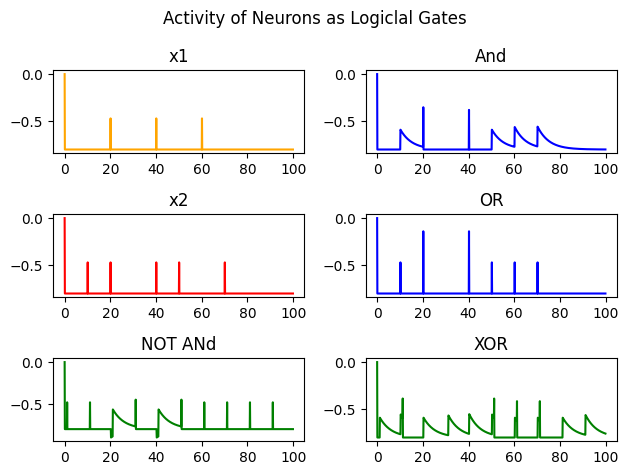

<Figure size 2000x1000 with 0 Axes>

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=2)
fig.suptitle('Activity of Neurons as Logiclal Gates')
plt.figure(figsize=(20,10))

ax[0, 0].set_title('x1')
ax[1, 0].set_title('x2')
ax[0, 1].set_title('And')
ax[1, 1].set_title('OR')
ax[2, 0].set_title('NOT ANd')
ax[2, 1].set_title('XOR')

ax[0, 0].plot(M_in.t/ms, M_in.v[0], c='orange')
ax[1, 0].plot(M_in.t/ms, M_in.v[1], c='red')
ax[0, 1].plot(M_and1.t/ms, M_and1.v[0], c='blue')
ax[1, 1].plot(M_or.t/ms, M_or.v[0], c='blue')
ax[2, 0].plot(M_not2.t/ms, M_not2.v[0], c='green')
ax[2, 1].plot(M_xor.t/ms, M_xor .v[0], c='green')


fig.tight_layout()


# Bernoulli Inputs

In [7]:
def message_computations(node, p1, p2):
  start_scope()

  T = 10000
  #------------------------Input-spikes----------------------

  v1 = array(np.random.binomial(size=1001, n=1, p= p1))
  spike_time = v1*linspace(0, 10000, 1001)
  times1 = array(spike_time[spike_time != 0])*ms
  indices1 = array(ones(len(times1)))

  inp1 = SpikeGeneratorGroup(2,indices1, times1)

  v2 = array(np.random.binomial(size=1001, n=1, p= p2))
  spike_time2 = v2*linspace(0, 10000, 1001)
  times2 = array(spike_time2[spike_time2 != 0])*ms
  indices2 = array(ones(len(times2)))

  inp2 = SpikeGeneratorGroup(2,indices2, times2)

  V_th = -0.50
  V_rest = -0.80

  eqs = '''
      dv/dt = (V_rest - v)/tau : 1
      tau : second
      '''
  #------------------------Input-neurons----------------------
  G_in = NeuronGroup(2, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
  G_in.tau = 10*ms

  feedforward1 = Synapses(inp1, G_in, on_pre='v += ww')
  feedforward1.connect(j='0')

  feedforward2 = Synapses(inp2, G_in, on_pre='v += ww')
  feedforward2.connect(j='1')

  spike_mon = SpikeMonitor(G_in)
  M_in = StateMonitor(G_in, 'v', record=True)


  #------------------------AND1-----------------------
  G_and1 = NeuronGroup(1, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
  G_and1.tau = 5*ms

  S1_and1 = Synapses(G_in, G_and1, on_pre='v += .21')
  S1_and1.connect(i='0')

  S2_and1 = Synapses(G_in, G_and1, on_pre='v += .21')
  S2_and1.connect(i='1')
  M_and1 = StateMonitor(G_and1, 'v', record=True)
  spike_mon_and1 = SpikeMonitor(G_and1)

  #-------------------------Or-------------------------
  G_or = NeuronGroup(1, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
  G_or.tau = 5*ms

  S1_or = Synapses(G_in, G_or, on_pre='v += .33')
  S1_or.connect(i='0')

  S2_or = Synapses(G_in, G_or, on_pre='v += .33')
  S2_or.connect(i='1')
  M_or = StateMonitor(G_or, 'v', record=True)
  spike_mon_or = SpikeMonitor(G_or)

  #------------------------NOT(AND1)----------------------
  G_not2 = NeuronGroup(1, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
  G_not2.tau = 5*ms

  # indices3 = array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  # times3 = array([1, 11, 21, 31, 41, 51, 61, 71, 81, 91])*ms
  # in_const = SpikeGeneratorGroup(1, indices3, times3)

  spike_time3 = np.arange(1, 10001, 10.0)
  times3 = array(spike_time3)*ms
  indices3 = array(zeros(len(times3)))
  in_const = SpikeGeneratorGroup(1,indices3, times3)

  S1_not2 = Synapses(in_const, G_not2, on_pre='v += .32')
  S1_not2.connect(i='0')

  S2_not2 = Synapses(G_and1 , G_not2, on_pre='v += -.1')
  S2_not2.connect(i='0')


  M_not2 = StateMonitor(G_not2, 'v', record=True)
  spike_mon_not2 = SpikeMonitor(G_not2)

  #------------------------AND2----------------------
  G_xor = NeuronGroup(1, eqs, threshold='v>V_th', reset='v = V_rest', method='exact')
  G_xor.tau = 5*ms

  S1_xor = Synapses(G_not2, G_xor, on_pre='v += .21')
  S1_xor.connect(i='0')

  S2_xor = Synapses(G_or, G_xor, on_pre='v += .21')
  S2_xor.connect(i='0')
  M_xor = StateMonitor(G_xor, 'v', record=True)
  spike_mon_xor = SpikeMonitor(G_xor)


  run(T*ms)
  if node =="XOR":
    return len(spike_mon_xor.i)/1000
  elif node == "equality":
    return len(spike_mon_and1.i)/(1000 - len(spike_mon_xor.i))
  else:
    return "Select XOR or Equality."

In [8]:
input_signals = [(.3,.4),(.2,.6),(.8,.5),(.7,.3),(.9,.7),(.6,.4),(.5,.1),(.3,.7)] # Each pair shows the Bernoulli parameters of the input messages

In [9]:
px1_array = np.array([x[0] for x in input_signals])
px2_array = np.array([x[1] for x in input_signals])

In [10]:
# sum-product solution for comparison
sum_product_xor = px1_array+px2_array-2*px1_array*px2_array
sum_product_equality = (px1_array*px2_array) / (1-px1_array-px2_array+2*px1_array*px2_array)

In [11]:
signal_out_xor = []
signal_out_equality = []
for i in input_signals:
  p1, p2 = i
  signal_out_xor.append((message_computations("XOR", p1, p2)))
  signal_out_equality.append((message_computations("equality", p1, p2)))

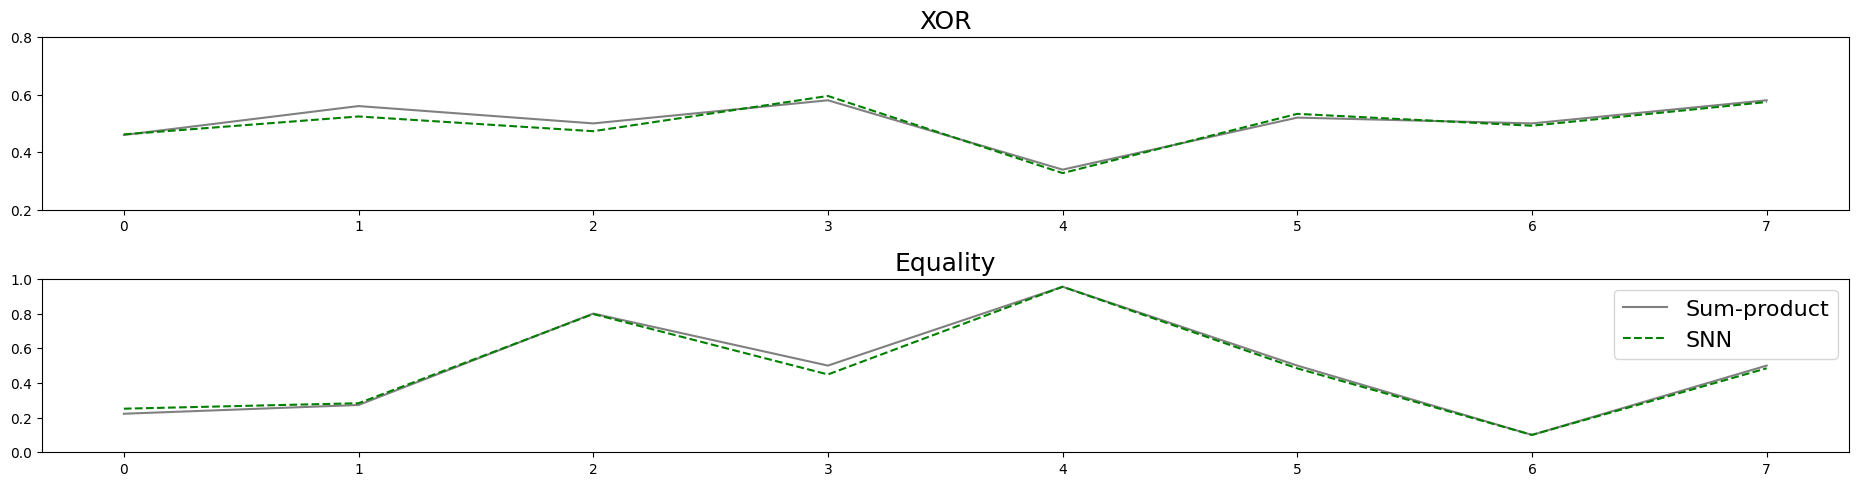

In [12]:
fig, ax = plt.subplots(nrows=2)
t = np.arange(0., 8, 1)

ax[0].set_title('XOR',fontsize=18)
ax[1].set_title('Equality',fontsize=18)

l11,= ax[0].plot(t, sum_product_xor, c='gray')
l21,= ax[0].plot(t, signal_out_xor, c='green',  linestyle='dashed')
plt.legend([l11, l21],['Sum-product', 'SNN'],fontsize=16)

l10,= ax[1].plot(t, sum_product_equality, c='gray')
l20,= ax[1].plot(t, signal_out_equality, c='green',  linestyle='dashed')
plt.legend([l10, l20],['Sum-product', 'SNN'],fontsize=16, loc='upper right')

ax[0].set_ylim([0.2, 0.8])
ax[1].set_ylim([0, 1])
fig.tight_layout()
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.gcf().set_size_inches(20, 5)


In [13]:

# np.save('sum_product_equality.npy', sum_product_equality)
# np.save('signal_out_equality.npy', signal_out_equality)


In [14]:

# np.save('sum_product_XOR.npy', sum_product_xor)
# np.save('signal_out_XOR.npy', signal_out_xor)
